In [1]:
import datetime, warnings, scipy 
import pandas as pd
import glob
import pytz
from time import time
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
#from mpl_toolkits.basemap import Basemap
from sklearn import metrics, linear_model
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit
from tqdm import tnrange, tqdm_notebook

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('LAS-JFK-ATL-utc-preprocessed.csv', index_col=0, 
                 parse_dates=[35, 36, 37, 38], 
                 infer_datetime_format ="%Y-%m-%d %H:%M:%S %Z%z")

In [3]:
df.head()

,Year,Quarter,Month,DayofMonth,DayOfWeek,UniqueCarrier,AirlineID,Carrier,TailNum,FlightNum,OriginAirportID,Origin,DestAirportID,Dest,CRSDepTime,DepTime,DepDelayMinutes,DepDel15,DepartureDelayGroups,CRSArrTime,ArrTime,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,Cancelled,CRSElapsedTime,ActualElapsedTime,Distance,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,SCH_START_DATETIME,SCH_END_DATETIME,ACT_START_DATETIME,ACT_END_DATETIME,SCH_START_DATETIME_MIN,SCH_END_DATETIME_MIN,ACT_START_DATETIME_MIN,ACT_END_DATETIME_MIN,TIME_FROM_LAST_SCH_LAND,TIME_FROM_LAST_FACT_LAND,LATE_ARRIVAL_BEFORE,FLIGHT_TIME_TO_MIDNIGHT
166,2012,1,1,1,7,MQ,20398,MQ,N815MQ,4406,12478,JFK,14492,RDU,745,739,0,0,-1,930,908,0,0,-2,0,105,89.0,427,2,0,0,0,0,0,2012-01-01 12:41:00,2012-01-01 14:26:00,2012-01-01 12:35:00,2012-01-01 14:04:00,761.0,866.0,755.0,844.0,35.0,53.0,18.0,12
188,2012,1,1,1,7,B6,20409,B6,N603JB,49,12478,JFK,14027,PBI,759,804,5,0,0,1058,1050,0,0,-1,0,179,166.0,1028,5,0,0,0,0,0,2012-01-01 12:55:00,2012-01-01 15:54:00,2012-01-01 13:00:00,2012-01-01 15:46:00,775.0,954.0,780.0,946.0,32.0,37.0,5.0,12
193,2012,1,1,1,7,B6,20409,B6,N630JB,341,12478,JFK,14986,SRQ,801,754,0,0,-1,1107,1048,0,0,-2,0,186,174.0,1041,5,0,0,0,0,0,2012-01-01 12:57:00,2012-01-01 16:03:00,2012-01-01 12:50:00,2012-01-01 15:44:00,777.0,963.0,770.0,944.0,143.0,171.0,28.0,12
198,2012,1,1,1,7,B6,20409,B6,N586JB,17,12478,JFK,11697,FLL,814,811,0,0,-1,1125,1108,0,0,-2,0,191,177.0,1069,5,0,0,0,0,0,2012-01-01 13:10:00,2012-01-01 16:21:00,2012-01-01 13:07:00,2012-01-01 16:04:00,790.0,981.0,787.0,964.0,59.0,56.0,-3.0,11
202,2012,1,1,1,7,MQ,20398,MQ,N816MQ,4416,12478,JFK,11278,DCA,815,812,0,0,-1,935,918,0,0,-2,0,80,66.0,213,1,0,0,0,0,0,2012-01-01 13:11:00,2012-01-01 14:31:00,2012-01-01 13:08:00,2012-01-01 14:14:00,791.0,871.0,788.0,854.0,35.0,57.0,22.0,11


In [4]:
df.shape

(2900144, 46)

In [5]:
df.columns

Index(['Year', 'Quarter', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
       'AirlineID', 'Carrier', 'TailNum', 'FlightNum', 'OriginAirportID',
       'Origin', 'DestAirportID', 'Dest', 'CRSDepTime', 'DepTime',
       'DepDelayMinutes', 'DepDel15', 'DepartureDelayGroups', 'CRSArrTime',
       'ArrTime', 'ArrDelayMinutes', 'ArrDel15', 'ArrivalDelayGroups',
       'Cancelled', 'CRSElapsedTime', 'ActualElapsedTime', 'Distance',
       'DistanceGroup', 'CarrierDelay', 'WeatherDelay', 'NASDelay',
       'SecurityDelay', 'LateAircraftDelay', 'SCH_START_DATETIME',
       'SCH_END_DATETIME', 'ACT_START_DATETIME', 'ACT_END_DATETIME',
       'SCH_START_DATETIME_MIN', 'SCH_END_DATETIME_MIN',
       'ACT_START_DATETIME_MIN', 'ACT_END_DATETIME_MIN',
       'TIME_FROM_LAST_SCH_LAND', 'TIME_FROM_LAST_FACT_LAND',
       'LATE_ARRIVAL_BEFORE', 'FLIGHT_TIME_TO_MIDNIGHT'],
      dtype='object')

### The number of delayed flights per month

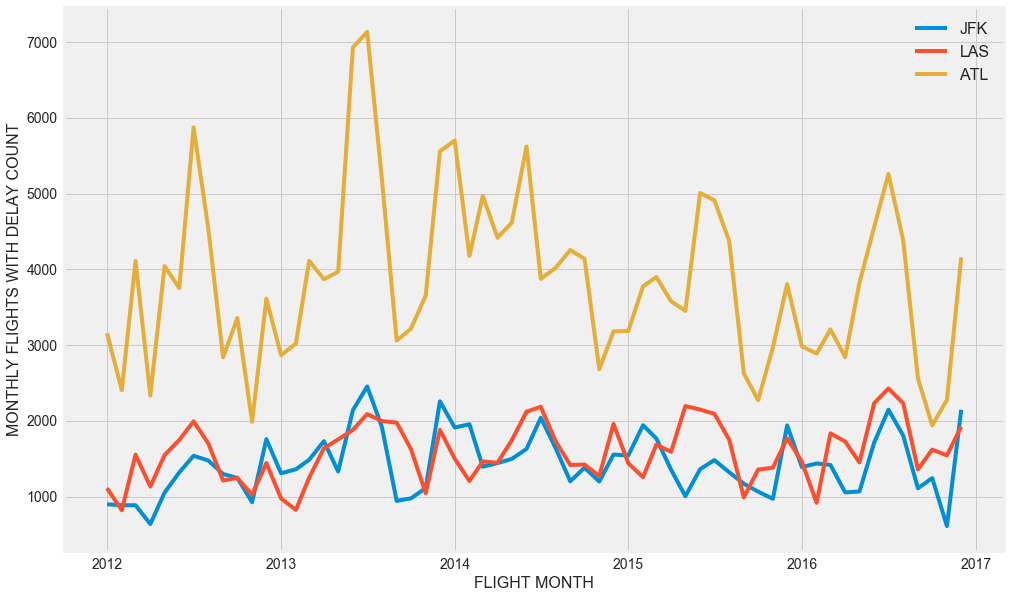

In [35]:
gr = df.groupby(['Year', 'Month', 'Origin'])['ArrDel15'].sum().reset_index()
gr.head()
gr['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH[gr.Origin == 'JFK'], gr.ArrDel15[gr.Origin == 'JFK'], label='JFK')
plt.plot(gr.YEAR_MONTH[gr.Origin == 'LAS'], gr.ArrDel15[gr.Origin == 'LAS'], label='LAS')
plt.plot(gr.YEAR_MONTH[gr.Origin == 'ATL'], gr.ArrDel15[gr.Origin == 'ATL'], label='ATL')
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.legend(fontsize=16)
plt.ylabel('MONTHLY FLIGHTS WITH DELAY COUNT', fontsize=16)
plt.grid('on')
plt.savefig('MONTHLY FLIGHTS WITH DELAY COUNT.png')

In [26]:
gr.head()

,Year,Month,Origin,ArrDel15,YEAR_MONTH
0,2012,1,ATL,3157,2012-01-01
1,2012,1,JFK,898,2012-01-01
2,2012,1,LAS,1111,2012-01-01
3,2012,2,ATL,2406,2012-02-01
4,2012,2,JFK,886,2012-02-01


The highest number of delayed flights is in July.

### Total number of flights per month

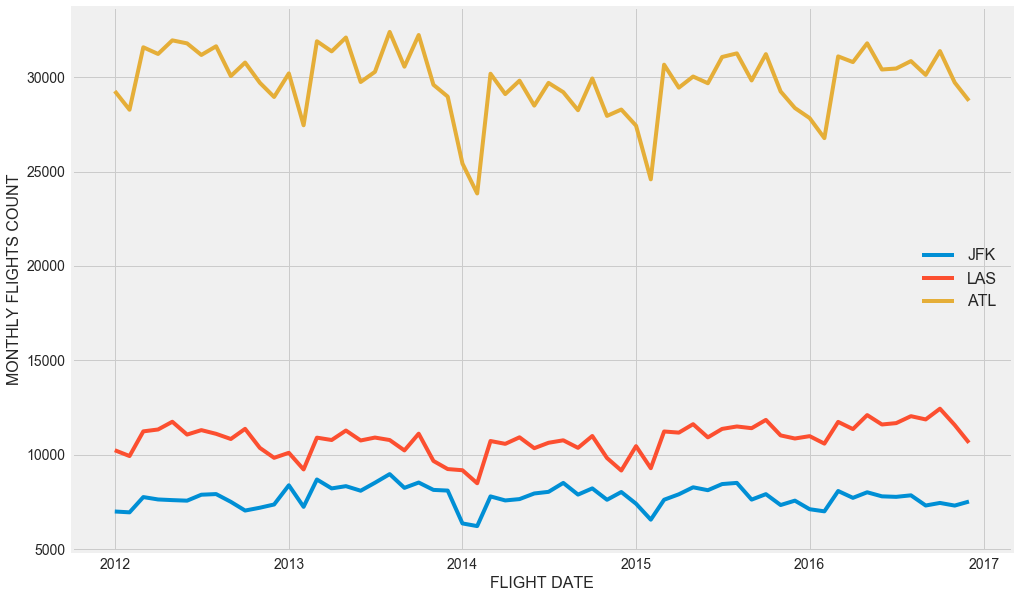

In [36]:
gr1 = df.groupby(['Year', 'Month', 'Origin'])['ArrDel15'].count().reset_index()
gr1['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr1.YEAR_MONTH[gr.Origin == 'JFK'], gr1.ArrDel15[gr.Origin == 'JFK'], label='JFK')
plt.plot(gr1.YEAR_MONTH[gr.Origin == 'LAS'], gr1.ArrDel15[gr.Origin == 'LAS'], label='LAS')
plt.plot(gr1.YEAR_MONTH[gr.Origin == 'ATL'], gr1.ArrDel15[gr.Origin == 'ATL'], label='ATL')
plt.xlabel('FLIGHT DATE', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS COUNT', fontsize=16)
plt.legend(fontsize=16)
plt.grid('on')

gr1.rename(index=str, columns={'ArrDel15':'TotalCount'}, inplace=True)

plt.savefig('MONTHLY FLIGHTS COUNT.png')

### Percentage of delayed flights per month

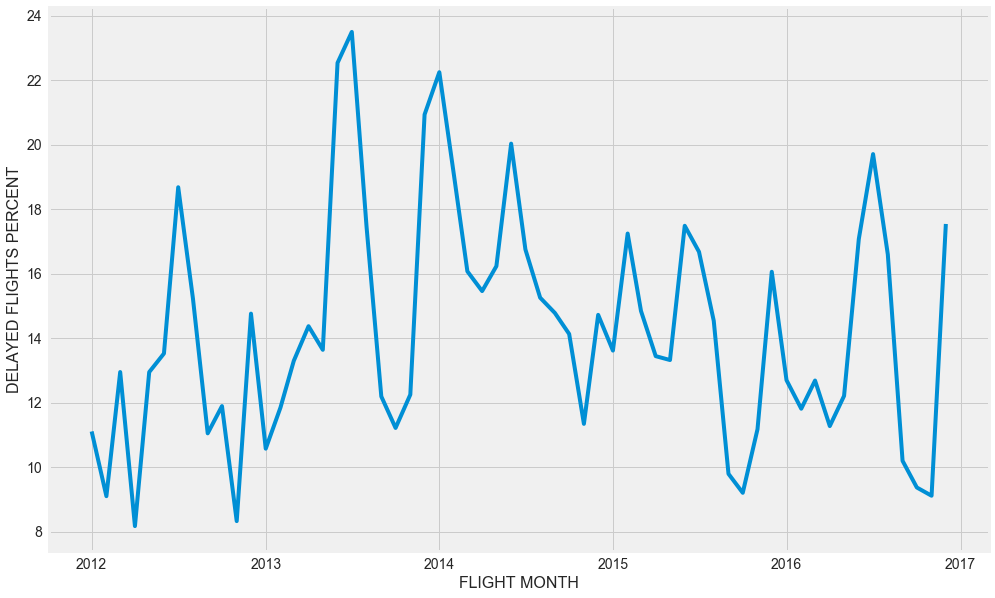

In [21]:
gr = gr.merge(gr1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, (gr.ArrDel15 / gr.TotalCount) * 100)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('DELAYED FLIGHTS PERCENT', fontsize=16)
plt.grid('on')

## Statistics per airport
### JFK

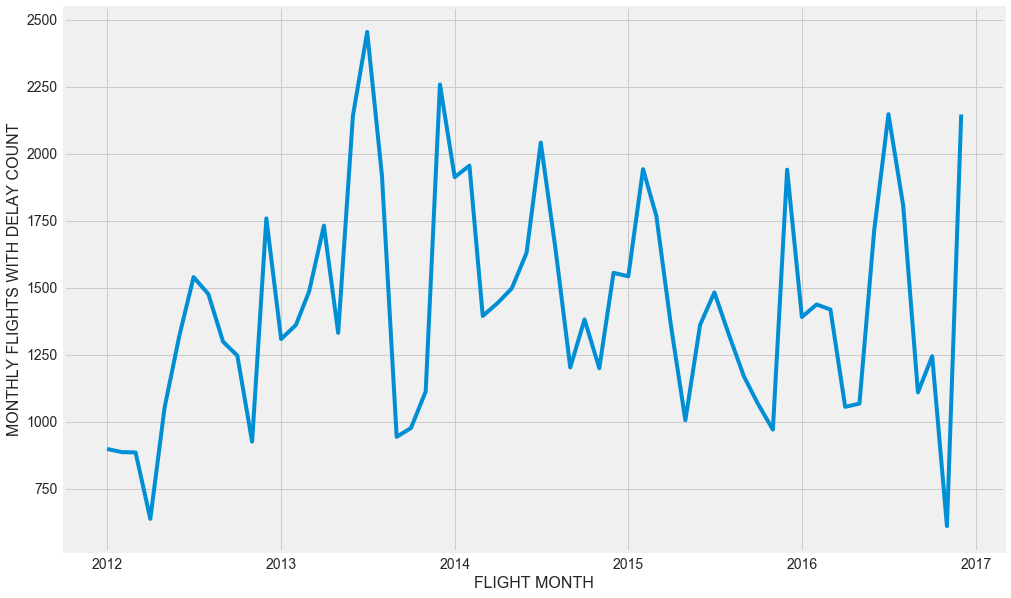

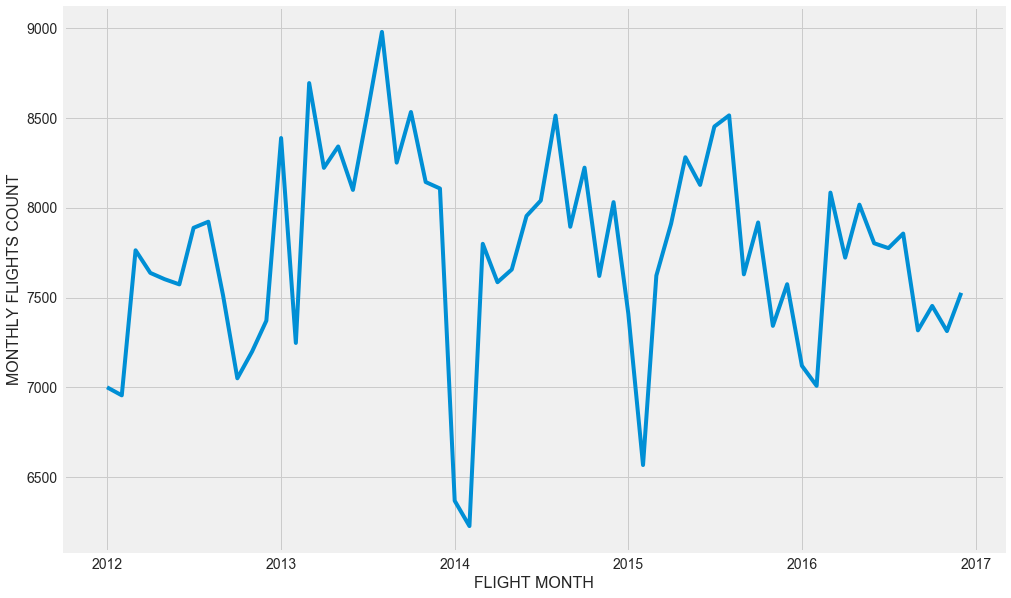

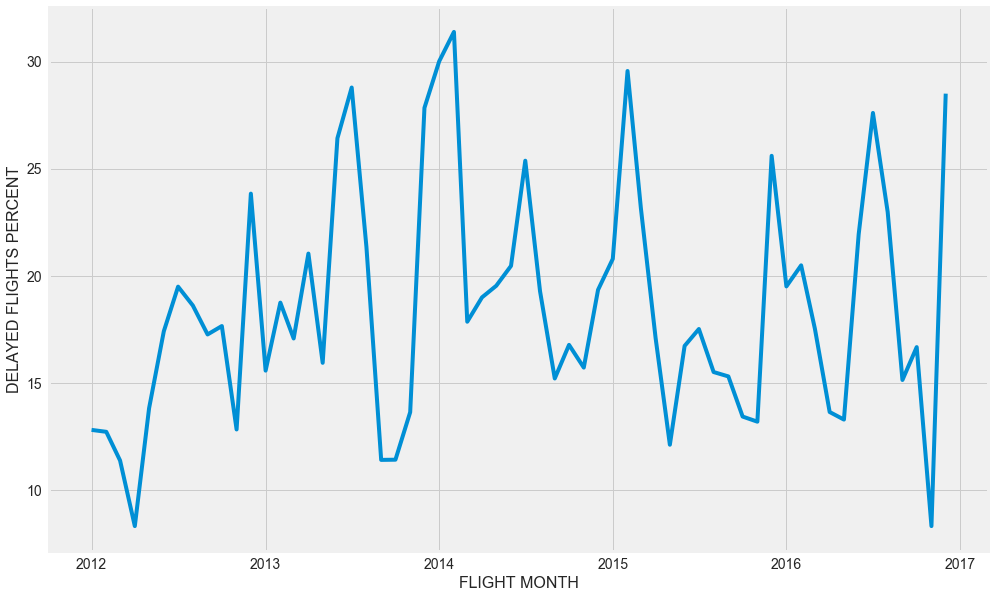

In [50]:
df1 = df[df.Origin == 'JFK']
gr = df1.groupby(['Year', 'Month'])['ArrDel15'].sum().reset_index()
gr['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, gr.ArrDel15)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS WITH DELAY COUNT', fontsize=16)
plt.grid('on')

gr1 = df1.groupby(['Year', 'Month'])['ArrDel15'].count().reset_index()
gr1['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr1.YEAR_MONTH, gr1.ArrDel15)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS COUNT', fontsize=16)
plt.grid('on')

gr1.rename(index=str, columns={'ArrDel15':'TotalCount'}, inplace=True)

gr = gr.merge(gr1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, (gr.ArrDel15 / gr.TotalCount) * 100)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('DELAYED FLIGHTS PERCENT', fontsize=16)
plt.grid('on')


### ATL

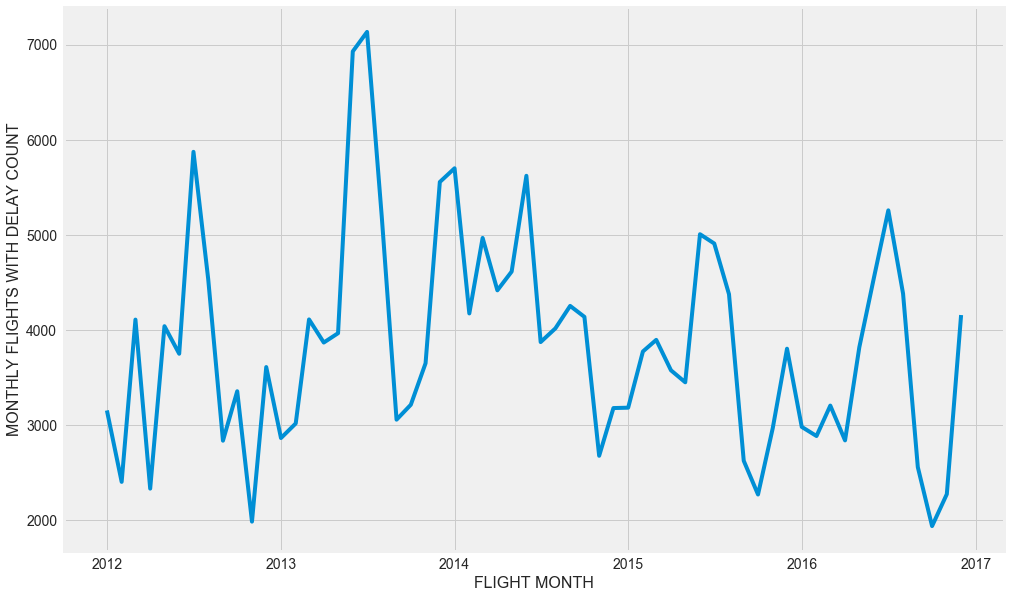

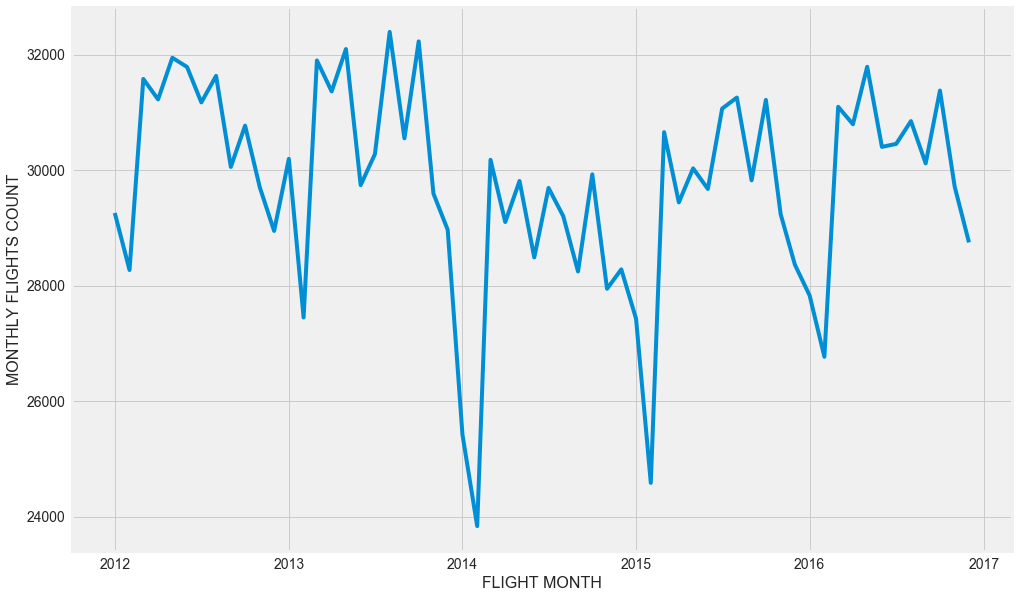

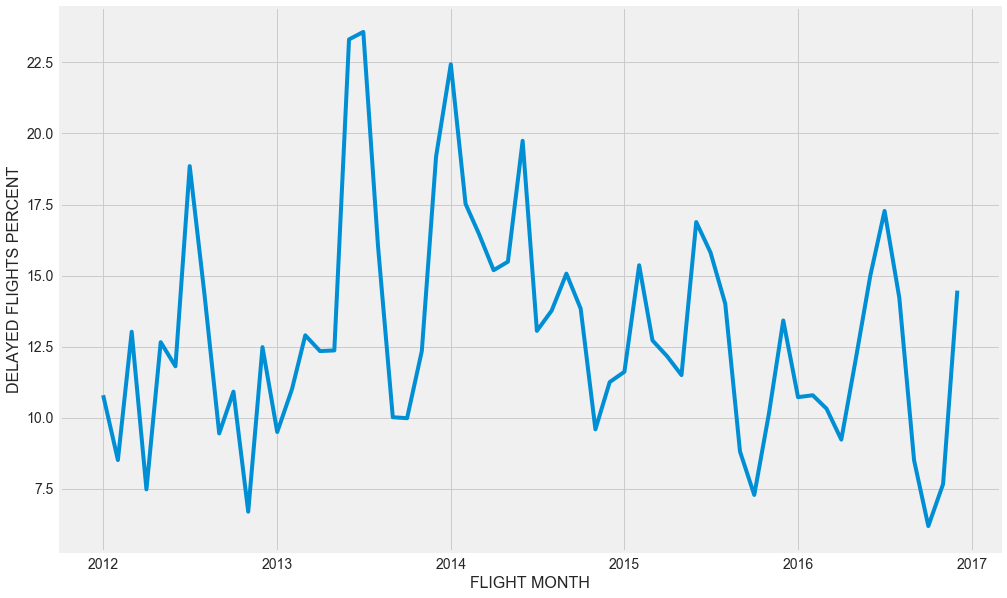

In [51]:
df1 = df[df.Origin == 'ATL']
gr = df1.groupby(['Year', 'Month'])['ArrDel15'].sum().reset_index()
gr['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, gr.ArrDel15)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS WITH DELAY COUNT', fontsize=16)
plt.grid('on')

gr1 = df1.groupby(['Year', 'Month'])['ArrDel15'].count().reset_index()
gr1['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr1.YEAR_MONTH, gr1.ArrDel15)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS COUNT', fontsize=16)
plt.grid('on')

gr1.rename(index=str, columns={'ArrDel15':'TotalCount'}, inplace=True)

gr = gr.merge(gr1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, (gr.ArrDel15 / gr.TotalCount) * 100)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('DELAYED FLIGHTS PERCENT', fontsize=16)
plt.grid('on')

### LAS

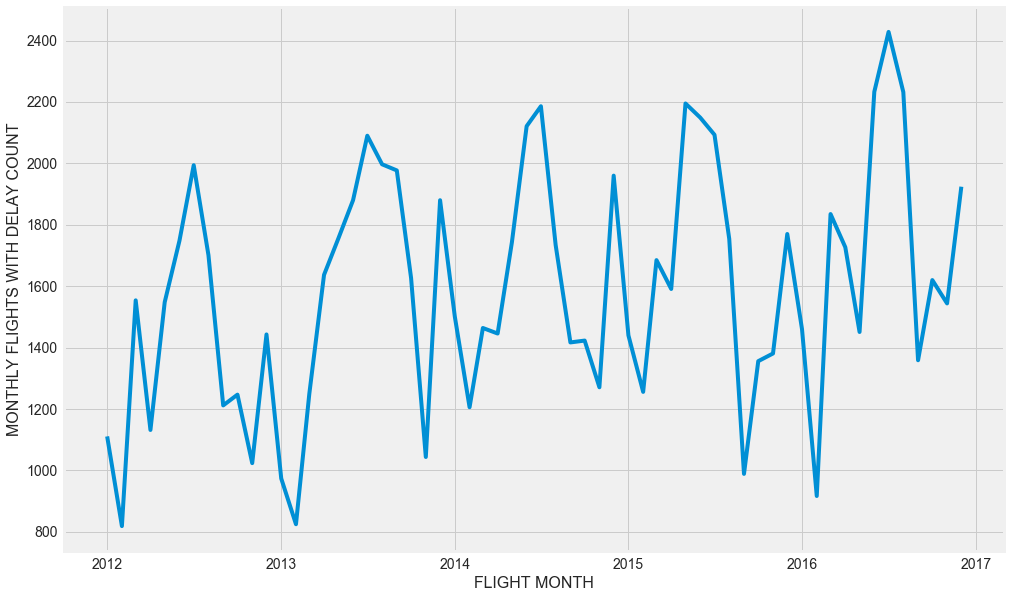

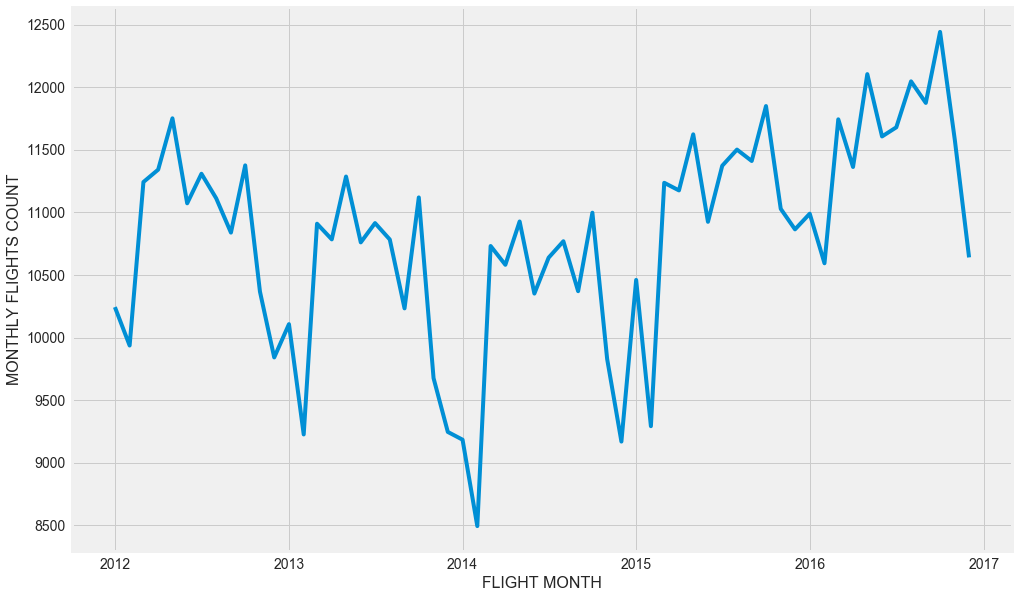

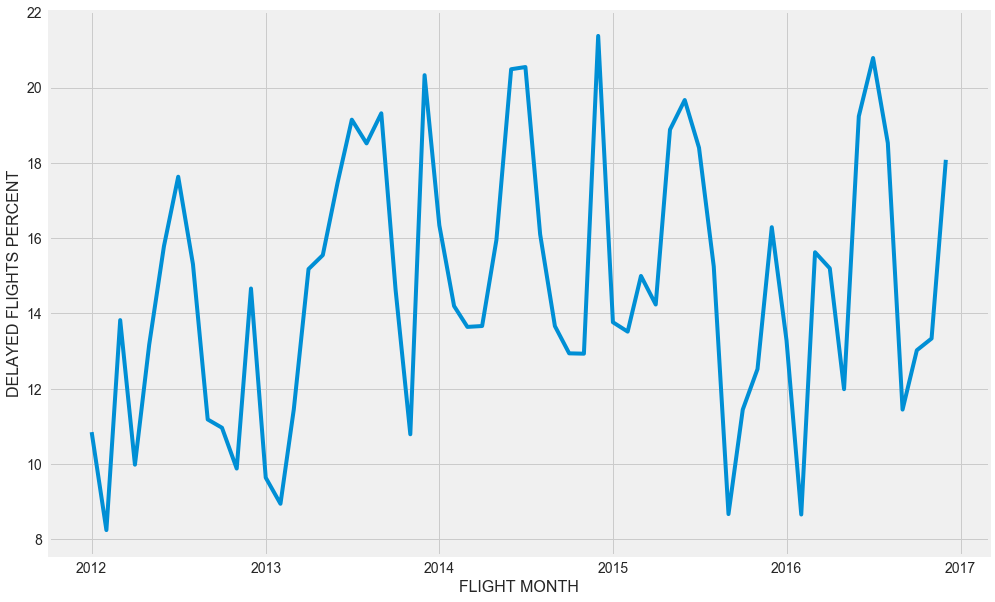

In [52]:
df1 = df[df.Origin == 'LAS']
gr = df1.groupby(['Year', 'Month'])['ArrDel15'].sum().reset_index()
gr['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, gr.ArrDel15)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS WITH DELAY COUNT', fontsize=16)
plt.grid('on')

gr1 = df1.groupby(['Year', 'Month'])['ArrDel15'].count().reset_index()
gr1['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr1.YEAR_MONTH, gr1.ArrDel15)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('MONTHLY FLIGHTS COUNT', fontsize=16)
plt.grid('on')

gr1.rename(index=str, columns={'ArrDel15':'TotalCount'}, inplace=True)

gr = gr.merge(gr1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, (gr.ArrDel15 / gr.TotalCount) * 100)
plt.xlabel('FLIGHT MONTH', fontsize=16)
plt.ylabel('DELAYED FLIGHTS PERCENT', fontsize=16)
plt.grid('on')

### Average Percentage of delays per day of week

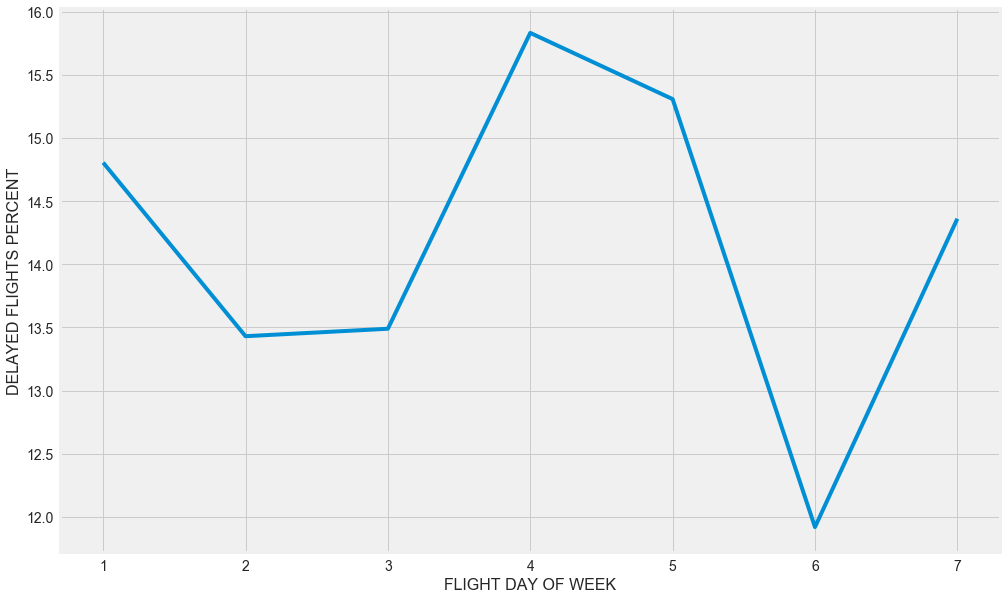

In [55]:
gr = df.groupby(['DayOfWeek'])['ArrDel15'].sum().reset_index()
#gr['YEAR_MONTH'] = gr.apply(lambda x: datetime.datetime(x.Year, x.Month, 1), axis=1)
gr1 = df.groupby(['DayOfWeek'])['ArrDel15'].count().reset_index()
gr1.rename(index=str, columns={'ArrDel15':'TotalCount'}, inplace=True)
gr = gr.merge(gr1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.DayOfWeek, (gr.ArrDel15 / gr.TotalCount) * 100)
plt.xlabel('FLIGHT DAY OF WEEK', fontsize=16)
plt.ylabel('DELAYED FLIGHTS PERCENT', fontsize=16)
plt.grid('on')

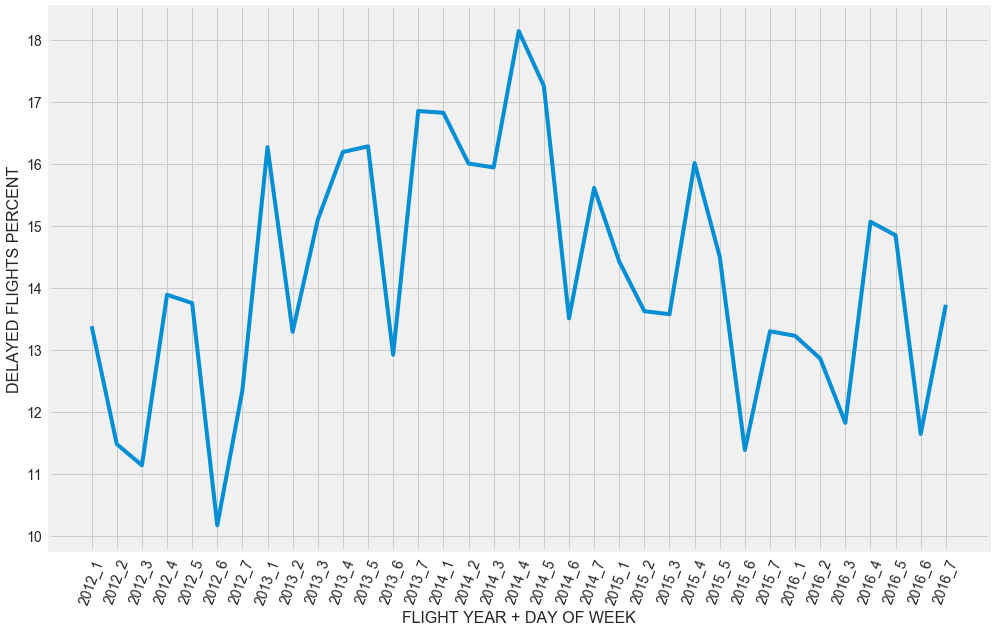

In [62]:
gr = df.groupby(['Year', 'DayOfWeek'])['ArrDel15'].sum().reset_index()
gr['YEAR_MONTH'] = gr.apply(lambda x: str(x.Year) + '_' + str(x.DayOfWeek), axis=1)
gr1 = df.groupby(['Year', 'DayOfWeek'])['ArrDel15'].count().reset_index()
gr1['YEAR_MONTH'] = gr.apply(lambda x: str(x.Year)  + '_' + str(x.DayOfWeek), axis=1)
gr1.rename(index=str, columns={'ArrDel15':'TotalCount'}, inplace=True)
gr = gr.merge(gr1)
plt.figure(figsize=(15, 10))
plt.xticks(size=14)
plt.yticks(size=14)
plt.plot(gr.YEAR_MONTH, (gr.ArrDel15 / gr.TotalCount) * 100)
plt.xlabel('FLIGHT YEAR + DAY OF WEEK', fontsize=16)
plt.ylabel('DELAYED FLIGHTS PERCENT', fontsize=16)
plt.xticks(rotation=70)
plt.grid('on')

### Average delay time in 2013 году

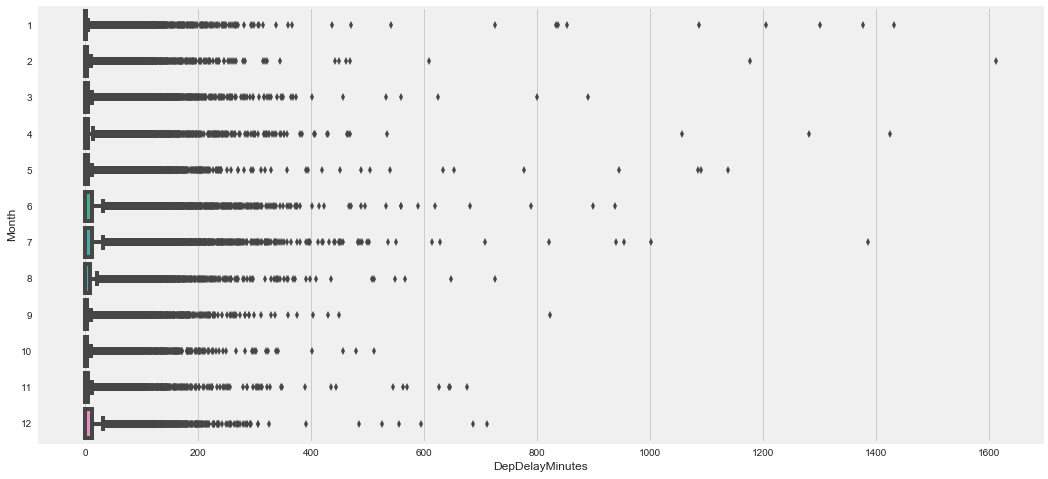

In [45]:
temp = df[df.Year == 2013]
plt.figure(figsize=(16, 8))
sns.boxplot(y="Month", x="DepDelayMinutes", data=temp, orient='h')

#### To make plot more beautiful, let's consider delays less than 100 minutes, other cases are very rare and aren't interesting for forecasting.

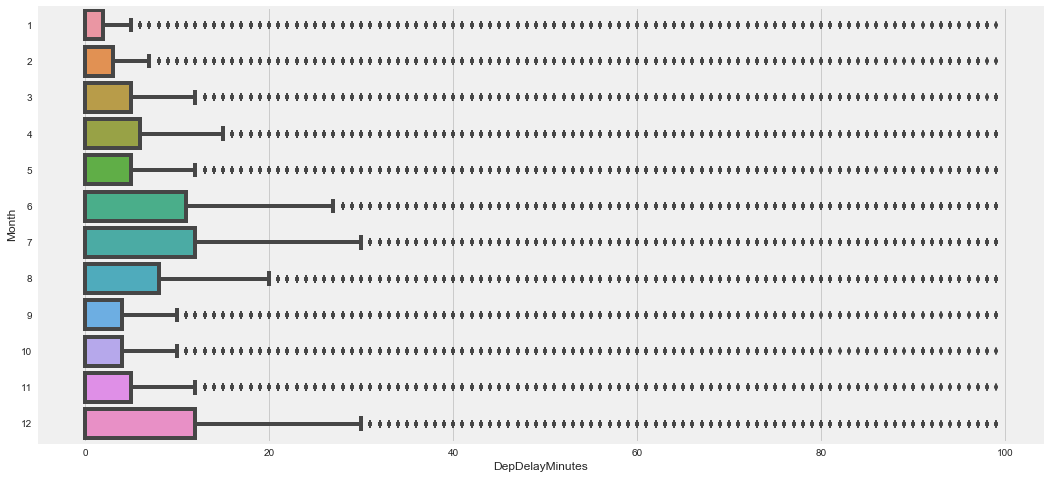

In [46]:
temp = temp[temp.DepDelayMinutes < 100]

plt.figure(figsize=(16, 8))
sns.boxplot(y="Month", x="DepDelayMinutes", data=temp, orient='h')

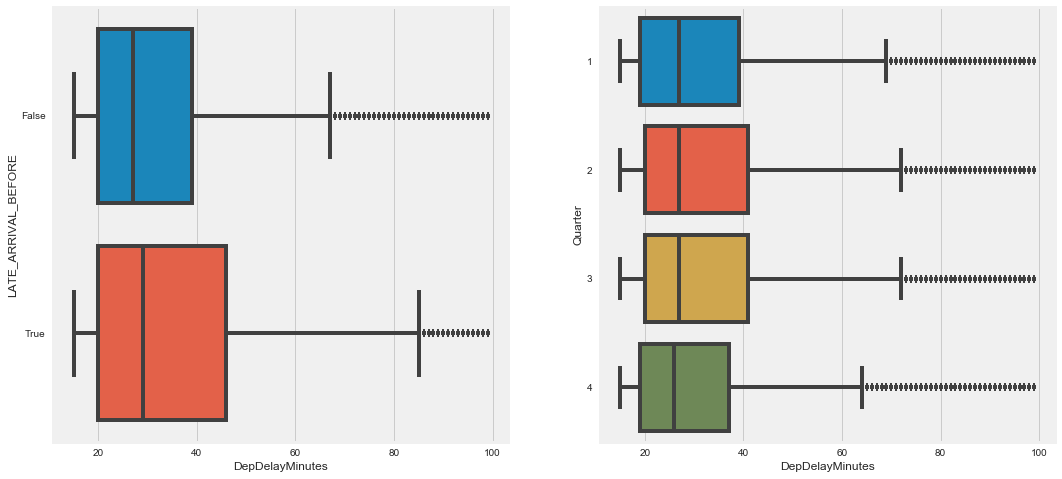

In [38]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
temp['LATE_ARRIVAL_BEFORE'] = temp['LATE_ARRIVAL_BEFORE'] > 15
sns.boxplot(y="LATE_ARRIVAL_BEFORE", x="DepDelayMinutes", data=temp, orient='h')
plt.subplot(1, 2, 2)
sns.boxplot(y="Quarter", x="DepDelayMinutes",data=temp, orient='h')

### Distribution of delay time

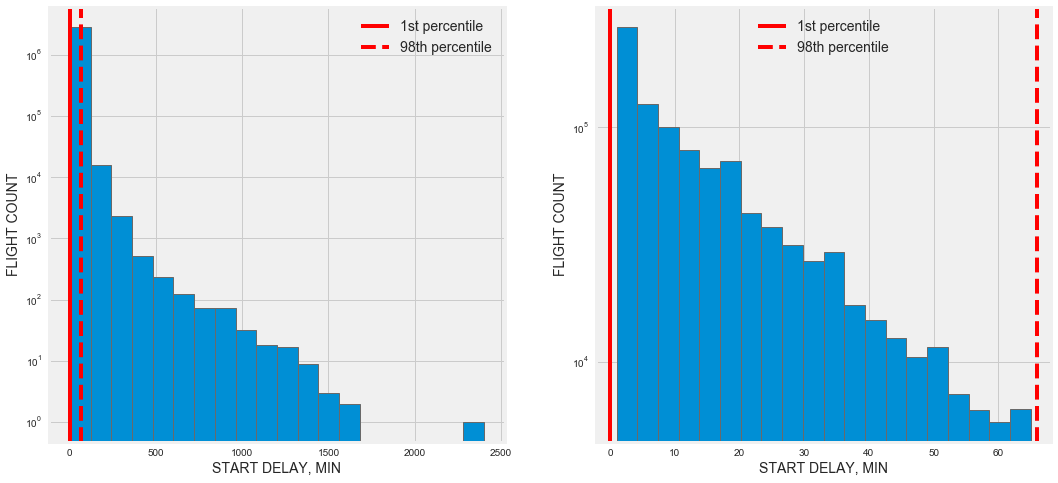

In [40]:
plt.figure(figsize=(16, 8))

plt.subplot(1, 2, 1)
df.DepDelayMinutes.hist(bins=20)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
delays = df.DepDelayMinutes[(df.DepDelayMinutes > np.percentile(df.DepDelayMinutes, 1)) & 
                        (df.DepDelayMinutes < np.percentile(df.DepDelayMinutes, 98))]
plt.hist(delays, bins=20)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

### Distribution of delay time per airport

#### JFK

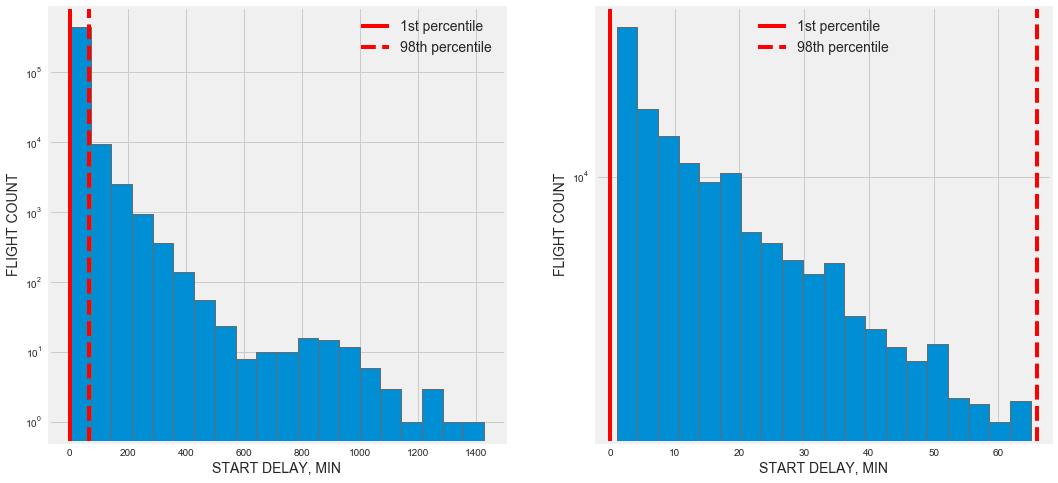

In [41]:
plt.figure(figsize=(16, 8))
df1 = df[df.Origin == 'JFK']
plt.subplot(1, 2, 1)
df1.DepDelayMinutes.hist(bins=20)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
delays = df1.DepDelayMinutes[(df.DepDelayMinutes > np.percentile(df.DepDelayMinutes, 1)) & 
                        (df.DepDelayMinutes < np.percentile(df.DepDelayMinutes, 98))]
plt.hist(delays, bins=20)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

#### LAS

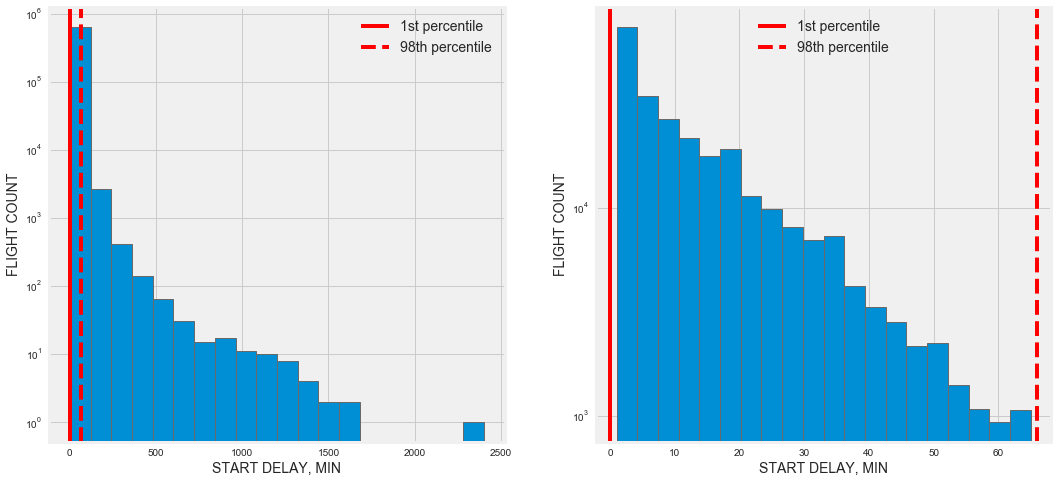

In [42]:
plt.figure(figsize=(16, 8))
df1 = df[df.Origin == 'LAS']
plt.subplot(1, 2, 1)
df1.DepDelayMinutes.hist(bins=20)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
delays = df1.DepDelayMinutes[(df.DepDelayMinutes > np.percentile(df.DepDelayMinutes, 1)) & 
                        (df.DepDelayMinutes < np.percentile(df.DepDelayMinutes, 98))]
plt.hist(delays, bins=20)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

#### ATL

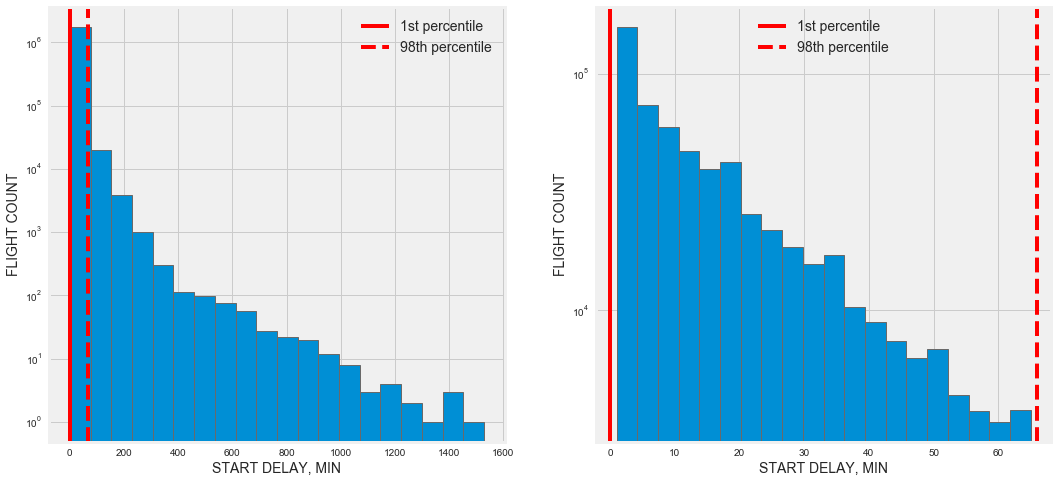

In [43]:
plt.figure(figsize=(16, 8))
df1 = df[df.Origin == 'ATL']
plt.subplot(1, 2, 1)
df1.DepDelayMinutes.hist(bins=20)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

plt.subplot(1, 2, 2)
delays = df1.DepDelayMinutes[(df.DepDelayMinutes > np.percentile(df.DepDelayMinutes, 1)) & 
                        (df.DepDelayMinutes < np.percentile(df.DepDelayMinutes, 98))]
plt.hist(delays, bins=20)
plt.xlabel('START DELAY, MIN', fontsize=14)
plt.ylabel('FLIGHT COUNT', fontsize=14)
plt.yscale('log')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 1), label='1st percentile', color='r')
plt.axvline(x=np.percentile(df.DepDelayMinutes, 98), label='98th percentile', color='r', ls='--')
plt.legend(fontsize=14)

### Flight time to midnight + delays

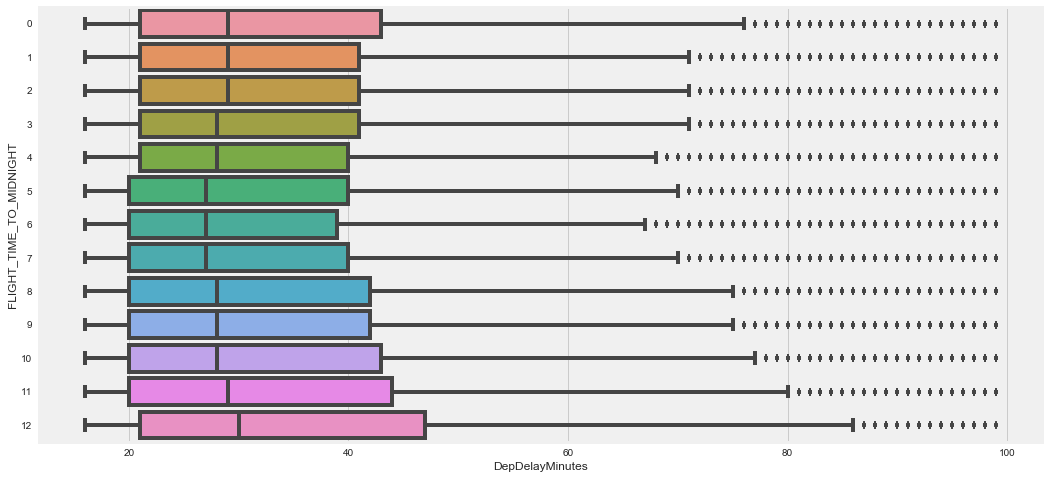

In [72]:
temp = df[df.DepDelayMinutes > 15]
temp = temp[temp.DepDelayMinutes < 100]
plt.figure(figsize=(16, 8))
sns.boxplot(y="FLIGHT_TIME_TO_MIDNIGHT", x="DepDelayMinutes", data=temp, orient='h')